In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('logistic_regression').getOrCreate()

from pyspark.ml.classification import LogisticRegression

In [2]:
data = spark.read.csv('./balanced.csv',inferSchema=True,header=True)

In [3]:
# Print data schema.
data.printSchema()

# Print data columns.
data.columns

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- blood pressure: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



['age',
 'gender',
 'height',
 'weight',
 'blood pressure',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio']

In [4]:
my_cols = data.select(['age',
 'weight',
 'blood pressure',
 'cholesterol',
 'gluc',
 'cardio'])

In [5]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [6]:
assembler = VectorAssembler(
    inputCols=['age',
             'weight',
             'blood pressure',
             'cholesterol',
             'gluc'],
            outputCol='features')

In [7]:
from pyspark.ml import Pipeline

###### Logistic Regression

In [8]:
lr = LogisticRegression(featuresCol='features',labelCol='cardio')

pipeline = Pipeline(stages=[assembler,lr])

In [9]:
train_data, test_data = data.randomSplit([0.8,0.2])

In [10]:
print(train_data.count())
train_data.show()

49611
+---+------+------+------+--------------+-----------+----+-----+----+------+------+
|age|gender|height|weight|blood pressure|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+--------------+-----------+----+-----+----+------+------+
| 30|     1|   159|  59.0|             3|          1|   1|    0|   0|     1|     0|
| 30|     1|   160|  59.0|             1|          1|   1|    0|   0|     1|     0|
| 30|     1|   175|  59.0|             3|          1|   1|    0|   0|     1|     0|
| 39|     1|   148|  65.0|             1|          1|   1|    0|   0|     1|     0|
| 39|     1|   150|  63.0|             3|          1|   1|    0|   0|     1|     0|
| 39|     1|   150|  67.0|             1|          1|   1|    0|   0|     1|     0|
| 39|     1|   150|  85.0|             4|          1|   1|    0|   0|     1|     0|
| 39|     1|   152|  60.0|             1|          1|   1|    0|   0|     1|     0|
| 39|     1|   152|  67.0|             1|          1|   1|    0|   0| 

In [11]:
print(test_data.count())
test_data.show()

12125
+---+------+------+------+--------------+-----------+----+-----+----+------+------+
|age|gender|height|weight|blood pressure|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+--------------+-----------+----+-----+----+------+------+
| 39|     1|   151|  50.0|             1|          1|   1|    0|   0|     1|     0|
| 39|     1|   151|  62.0|             1|          1|   1|    0|   0|     1|     0|
| 39|     1|   153|  70.0|             2|          1|   1|    0|   0|     1|     0|
| 39|     1|   153|  91.0|             3|          1|   1|    0|   0|     1|     0|
| 39|     1|   156|  69.0|             3|          1|   1|    0|   0|     1|     0|
| 39|     1|   156|  70.0|             3|          3|   3|    0|   0|     0|     0|
| 39|     1|   156|  87.0|             3|          1|   1|    0|   0|     0|     1|
| 39|     1|   157|  58.0|             1|          1|   1|    0|   0|     1|     0|
| 39|     1|   158|  75.0|             3|          1|   1|    0|   0| 

In [12]:
fit_model = pipeline.fit(train_data)

results = fit_model.transform(test_data)

In [13]:
results.select('cardio','prediction').show()

+------+----------+
|cardio|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
AUC = my_eval.evaluate(results)

AUC

0.6844388937963359

###### Random Forest

In [15]:
output = assembler.transform(data)

data = output.select('features','cardio')

train_data,test_data = data.randomSplit([0.8,0.2])

In [16]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol='cardio',featuresCol='features',numTrees=100)

rfc_model = rfc.fit(train_data)

rfc_predictions = rfc_model.transform(test_data)

In [17]:
rfc_predictions.select('cardio','prediction').show()

+------+----------+
|cardio|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     1|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [18]:
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'cardio')

In [19]:
print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))

RFC
0.7534553920562758


###### 7.3 Search for patterns

(array([7366.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4896.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

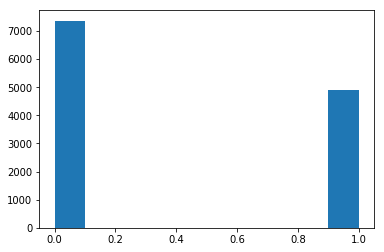

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rf_out = np.array(rfc_predictions.select('prediction').collect())
plt.hist(rf_out)

(array([7366.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4896.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

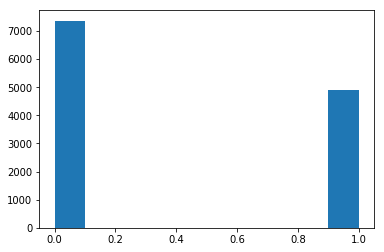

In [21]:
lr_out = np.array(results.select('prediction').collect())
plt.hist(rf_out)